
Quote from the website:

This data originally came from Crowdflower's Data for Everyone library.

As the original source says,

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

The data we're providing on Kaggle is a slightly reformatted version of the original source. It includes both a CSV file and SQLite database. The code that does these transformations is available on GitHub

For example, it contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines:



URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

Data dictionary:

tweed_id:                   ID of the Tweet.
airline_sentiment:          Labelled column for the sentiment of the Tweet itself. This is the target attribute of the dataset.
negative_reason:            Reasons if the sentiment is negative.
negativereason_confidence:  The confidence of negative reason.
airline:                    Name of the airline.
airline_sentiment_gold:     Sentiment about the airline.
name:                       Username of the tweet.
negativereason_gold:        Reason of negative.
retweet_count:              Number of retweets.
text:                       Content of the tweet.
tweet_coord:                coordination of the Tweet.
tweet_created:              Date and time when the Tweet is made.
tweet_location:             Place when the Tweet is made.
user_timezone:              Timezone of the user.




In [129]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

import re
import string
import unicodedata
import contractions
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (recall_score, accuracy_score, confusion_matrix,
                             classification_report, f1_score, precision_score,
                             precision_recall_fscore_support)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import wordcloud
from wordcloud import STOPWORDS, WordCloud

# Remove the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Set the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/teohkhenghong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/teohkhenghong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/teohkhenghong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [130]:
df = pd.read_csv('Tweets.csv')

In [131]:
print(df.shape)
df.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Analysis: Based on the execution output, there are 14,640 records in the dataset, with 15 attributes/columns.



In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [133]:
# Check for empty values in each column.
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Analysis: There are some missing values in some columns,

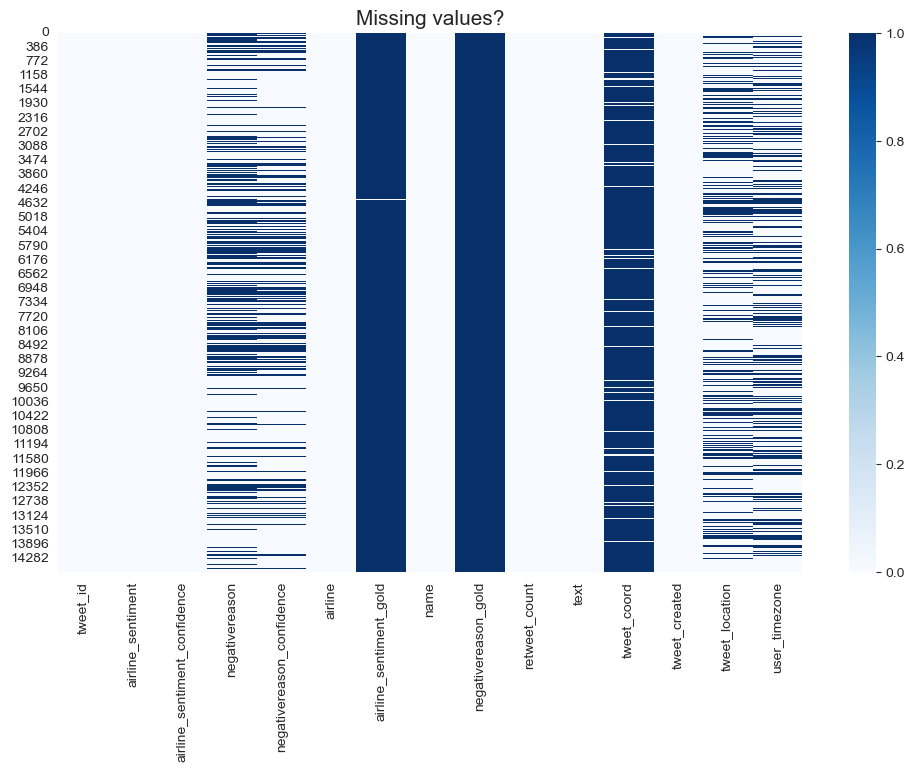

In [134]:
plt.figure(figsize=(12,7))
sns.heatmap(df.isnull(), cmap = "Blues")                       #Visualization of missing value using heatmap
plt.title("Missing values?", fontsize = 15)
plt.show()

Analysis: The heatmap above shows the missing values' distribution in the dataset. The darker the value

In [135]:
print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

Analysis: From the above, airline_sentiment_gold, negativereadson_gold and twwet_coord have 99.73%, 99.78% and 93.04% missing values respectively.

Hence, remove the columns that have most of the distribution with empty values to improve the data quality, computational efficiency, interpretability of the dataset for the model building process later.

In [136]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [137]:
negativereason_freq = df.groupby('negativereason').size()

In [138]:
negativereason_freq

negativereason
Bad Flight                      580
Can't Tell                     1190
Cancelled Flight                847
Customer Service Issue         2910
Damaged Luggage                  74
Flight Attendant Complaints     481
Flight Booking Problems         529
Late Flight                    1665
Lost Luggage                    724
longlines                       178
dtype: int64

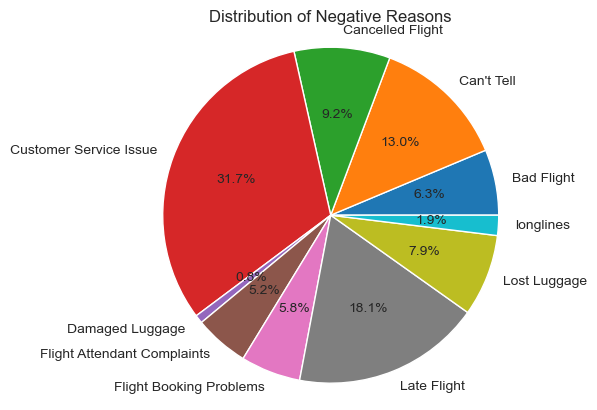

In [139]:
# Extract the unique values and their frequencies
labels = negativereason_freq.index
sizes = negativereason_freq.values

# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Negative Reasons')

# Display the chart
plt.show()

Analysis: Diving into the negativereasons column, customer service issue attributes 31.7% of the distribution, 18.1% of Late Flight, which covers almost 50% of the distribution. Followed by 13.0% Can't tell, 9.2% Cancelled Flight, combined with first 2 main reasons, they have covered 70% of the negative sentiments of the customers.

# Check Record duplicates

In [140]:
df.duplicated().sum()

39

Analysis: Based on the output above, there are 39 duplicates found in the dataset.

In [141]:
df.drop_duplicates(inplace = True) # Drop duplicates

In [142]:
df.duplicated().sum()

0

Analysis: After the execution, there are no more duplicates in the dataset.

In [143]:
np.random.seed(42)

# also look at random 10 sample rows
df.sample(n=5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
169,569459618881019905,neutral,1.0000,NaN,NaN,Virgin America,NewsSWA,0,@VirginAmerica to jump into the Dallas-Austin ...,2015-02-22 03:32:07 -0800,FL410,Sydney
9355,569970608693493760,negative,1.0000,Customer Service Issue,0.6444,US Airways,smaguire2,0,@USAirways even if I was the single most unrea...,2015-02-23 13:22:37 -0800,NaN,Atlantic Time (Canada)
3013,568800389903962112,negative,1.0000,Cancelled Flight,0.3467,United,Azraellius,0,@united haha and you have to clean a plane tha...,2015-02-20 07:52:35 -0800,"Orlando, FL",Eastern Time (US & Canada)
1475,569705838870466561,negative,0.6939,Flight Booking Problems,0.6939,United,JoeRychalsky,0,@united I can't find any Late Flight evening f...,2015-02-22 19:50:31 -0800,"Wilmington, Delaware",Eastern Time (US & Canada)
7420,569620168671756288,neutral,0.6376,NaN,0.0000,Delta,Ben_Harriton,0,@JetBlue of my tray table is broken what do i do?,2015-02-22 14:10:05 -0800,NaN,NaN


Analysis: The random seed of the Numpy library is fixed to a constant number before the rest of the modelling process. This is to ensure that the result reproducibility is guaranteed.

This consistency is needed  during the following process:
* Initialization of model weights.
* Splitting data to train and test datasets.
* Generation of random numbers for cross-validation.
* Control variability of the random processes.
* Allow better debugging and troubleshooting.

Analysis: There are still many empty values across from the remaining columns, which will be further analyzed during the Exploratory Data Analysis (EDA) section.

# Exploratory Data Analysis (EDA)

EDA is an important process in pre-data modelling as it analyse the patterns and distributions of the dataset to help understand the dataset deeper and gain insights before ready for modelling process.
Hence, the steps are based on the execution outputs with the recommended approach to ensure data quality is achieved.

In [144]:
# Describe the dataset.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14601.0,5.692156e+17,7.782706e+14,5.675883e+17,5.685581e+17,5.694720e+17,5.698884e+17,5.703106e+17
airline_sentiment_confidence,14601.0,8.999022e-01,1.629654e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10501.0,6.375749e-01,3.303735e-01,0.000000e+00,3.605000e-01,6.705000e-01,1.000000e+00,1.000000e+00
retweet_count,14601.0,8.280255e-02,7.467231e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


Analysis: From the table above, here are the observations:

* tweet_id appears to be unique, as the mean value of 5.69E+17 is very high, which suggests that each Tweet has distinct ID assoociated with it.
* airline_sentiment_confidence has mean value of 0.9 which means that sentiment classification is generally confident.
* negativereason_confidence has mean value of 0.638 suggestsa moderate level of confidence. However, there are lower count (10,501) than overall count (14,601) indicates that there are some missnig attributes in the attribute.
* retweet_count has average value of 0.0828 indicates that most of the tweets have low retweets. But, there are some Tweets got retweeted as high as 44 times.
* tweet_id, airline_sentiment_confidence and retweet_count have no missing values.
* tweet_id, airline_sentiment_confidence and retweet_count have relatively small standard deviations, means the values on these attributes doesn't deviate too far from mean.
* All columns' median (50%) values are bigger than mean, which shows data imbalance.

In [145]:
# Check unique value of airline_sentiment.
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [146]:
airline_sentiment_freq = df.groupby('airline_sentiment').size()

Analysis: airline_sentiment has 3 distinct values, which are neutral, positive and negative.

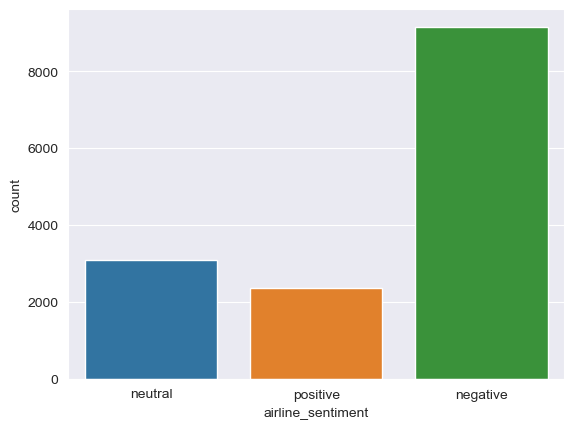

In [147]:
ax = sns.countplot(x="airline_sentiment", data=df)

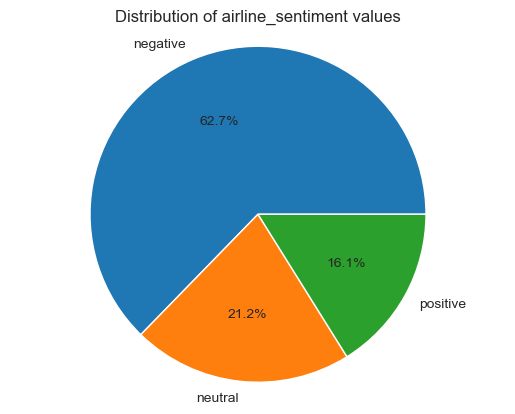

In [148]:
# Extract the unique values and their frequencies
labels = airline_sentiment_freq.index
sizes = airline_sentiment_freq.values

# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of airline_sentiment values')

# Display the chart
plt.show()

Analysis: There are 62.7 % of negative, 16.1% of positive and 21.2% of neutral sentiments from the airlines that the users have taken.

In [149]:
airline_freq = df.groupby('airline').size()

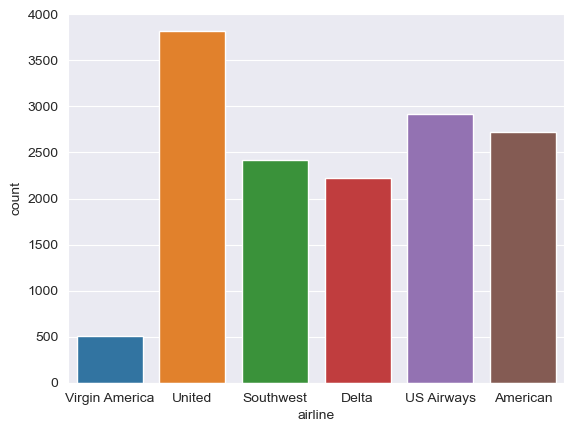

In [150]:
ax = sns.countplot(x="airline", data=df)

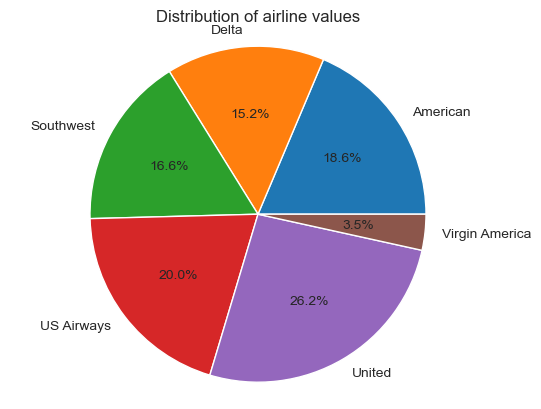

In [151]:
# Extract the unique values and their frequencies
labels = airline_freq.index
sizes = airline_freq.values

# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of airline values')

# Display the chart
plt.show()

Analysis: The user tweets about the airlines are more distributed, with exception of Virgin America. The airline

In [152]:
# Calculate the cross-tabulation of airline and airline_sentiment
crosstab_sentiments = pd.crosstab(df['airline'], df['airline_sentiment'])
companies = list(crosstab_sentiments.index)

# Create a bar chart for each sentiment category
bar_charts = []
sentiment_labels = list(crosstab_sentiments.columns)
for sentiment_label in sentiment_labels:
    sentiment_values = list(crosstab_sentiments[sentiment_label])
    bar_chart = go.Bar(name=sentiment_label, x=companies, y=sentiment_values)
    bar_charts.append(bar_chart)

# Configure the layout of the figure
layout = go.Layout(
    barmode='stack',
    title='Sentiment Distribution by Airline',
    xaxis=dict(title='Airline'),
    yaxis=dict(title='Sentiment Distribution')
)

# Create the figure with the bar charts and layout
fig = go.Figure(data=bar_charts, layout=layout)

# Show the figure
fig.show()

Analysis: A crossplot has been made to show the sentiments of the Twitter users across the airlines. Based on the above output, most of Tweets are negative about their airlines.

In [153]:
crosstab_neg_reasons = pd.crosstab(df['airline'], df['negativereason'])

print(crosstab_neg_reasons)

negativereason  Bad Flight  Can't Tell  Cancelled Flight  \
airline                                                    
American                87         198               242   
Delta                   64         186                51   
Southwest               90         159               162   
US Airways             104         246               189   
United                 216         379               181   
Virgin America          19          22                18   

negativereason  Customer Service Issue  Damaged Luggage  \
airline                                                   
American                           760               12   
Delta                              199               11   
Southwest                          391               14   
US Airways                         811               11   
United                             681               22   
Virgin America                      60                4   

negativereason  Flight Attendant Complaints  F

In [154]:
# Calculate the cross-tabulation of airline and negative reason
companies = list(crosstab_neg_reasons.index)

# Create a bar chart for each negative reason category
bar_charts = []
reason_labels = list(crosstab_neg_reasons.columns)
for reason_label in reason_labels:
    reason_values = list(crosstab_neg_reasons[reason_label])
    bar_chart = go.Bar(name=reason_label, x=companies, y=reason_values)
    bar_charts.append(bar_chart)

# Configure the layout of the figure
layout = go.Layout(
    barmode='stack',
    title='Negative Reasons Distribution by Airline',
    xaxis=dict(title='Airline'),
    yaxis=dict(title='Negative Reasons Distribution')
)

# Create the figure with the bar charts and layout
fig = go.Figure(data=bar_charts, layout=layout)

# Show the figure
fig.show()

Analysis: Based on the visualization above the most complaint made by the users are the Customer Service Issue, followed by Late Flight.

## Dropping neutral sentiments

Dropping neutral sentiments of the dataset. This is because:
* Reduce dimensionality: The model will only have to predict binary classication task/
* Neutral sentiment does not bring more value for analysis.
* Easier to balance the dataset.

In [ ]:
df.drop(df.loc[df['Airline_Sentiment']=='neutral'].index, inplace=True)

TODO

In [ ]:
data = df[["airline_sentiment", "Text"]]
data.head()

In [ ]:
X = df["text"]
y = df["airline_sentiment"]

In [ ]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tfidf = TfidfVectorizer(stop_words="english")

In [ ]:
tfidf.fit(Xtrain)

In [ ]:
print(tfidf.get_feature_names())

In [ ]:
print(tfidf.vocabulary_)

In [ ]:
data[data["airline_sentiment"]=="negative"]["text"]

In [ ]:
count_vect = CountVectorizer(stop_words="english")
neg_matrix = count_vect.fit_transform(data[data["airline_sentiment"]=="negative"]["text"])
freqs = zip(count_vect.get_feature_names(), neg_matrix.sum(axis=0).tolist()[0])
# Sort from largest to smallest
print(sorted(freqs, key=lambda x: -x[1])[:100])

Wordcloud for positive reasons

In [ ]:
new_df=data[data['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word and not word.startswith('@') and word != 'RT'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',width=3000,height=2500).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Wordcloud for negative reasons

In [ ]:
new_df=data[data['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word and not word.startswith('@') and word != 'RT'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',width=3000,height=2500).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
le = LabelEncoder()
le.fit(data['air'])

data['airline_sentiment_encoded'] = le.transform(data['airline_sentiment'])
data.head()

# Preprocessing the tweet text data

Now, we will clean the tweet text data and apply classification algorithms on it.

In [ ]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

In [ ]:
data['clean_tweet']=data['text'].apply(lambda x: tweet_to_words(x))

In [ ]:
data.info()

In [ ]:
x = data.clean_tweet
y = data.airline_sentiment

print(len(x), len(y))

The data is split in the standard 80,20 ratio

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

In [ ]:
# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

In [ ]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [ ]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)
vect_tunned

# Model Building

# Support Vector Machines (SVMs)

In [ ]:
#training SVM model with linear kernel
#Support Vector Classification-wrapper around SVM
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state = 10)
model.fit(x_train_dtm, y_train)
#predicting output for test data
pred = model.predict(x_test_dtm)

In [ ]:
#accuracy score
accuracy_score(y_test,pred)

In [ ]:
#building confusion matrix
cm = confusion_matrix(y_test, pred)
cm

In [ ]:
#defining the size of the canvas
plt.rcParams['figure.figsize'] = [15,8]
#confusion matrix to DataFrame
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1',], index = ['Actual:0','Actual:1',])
#plotting the confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Paired', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(y_test,pred))

As you can see above we have plotted the confusion matrix for predicted sentiments and actual sentiments (negative and positive)
SVM Classifier gives us the best accuracy score i.e 91% precision scores according to the classification report.
The confusion matrix shows the TP,TN,FP,FN for sentiments(negative, positive)

# Random Forest

In [ ]:

# Data Preprocessing

def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "lxml").get_text()
    # Convert to lowercase
    text = text.lower()
    # Expand contractions
    text = contractions.fix(text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text


# Data Loading and Exploration

df = pd.read_csv("dataset.csv")

# ... (additional code for data exploration)

# Data Preprocessing

df["clean_text"] = df["text"].apply(preprocess_text)

# ... (additional code for further preprocessing)


# Model Building and Evaluation

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["airline_sentiment"], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize and train the model
model = RandomForestClassifier()
model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = model.predict(X_test_vectorized)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Base BERT

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='tf'
)

X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='tf'
)

# Convert the tokenized data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train_encoded),
    y_train.values
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test_encoded),
    y_test.values
))

# Define the BERT model architecture
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=model.compute_loss,
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset.shuffle(100).batch(16),
    epochs=5,
    batch_size=16,
    validation_data=test_dataset.batch(16)
)

# Make predictions
y_pred = np.argmax(model.predict(test_dataset.batch(16)).logits, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)